# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


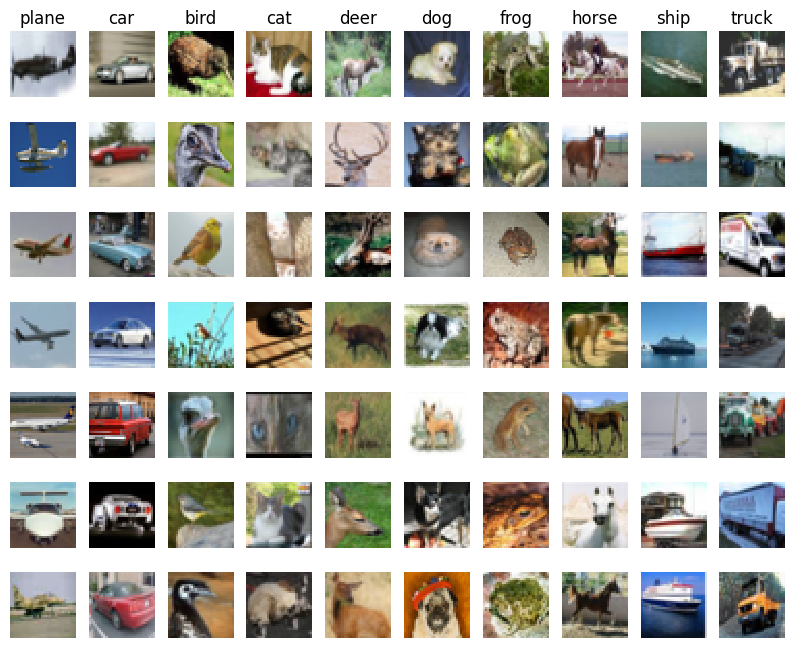

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    # 在每一个y++的loop中获取对应class的索引序列. 例如y_train = [1, 2, 1, 3, 5, 0, 6, 1], y = 1, 则idxs = [0, 2, 7]
    idxs = np.flatnonzero(y_train == y)
    # 从idxs中随机选择samples_per_class个索引. 例如idxs = [0, 2, 7], samples_per_class = 2, 则idxs = [0, 2]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    # 绘制每个class的样本
    for i, idx in enumerate(idxs):
        # 以第一个class的位置为例, plt_idx的值为1, 11, 21, 31, 41, 51, 61
        plt_idx = i * num_classes + y + 1
        # subplot(行数, 列数, 子图索引)
        plt.subplot(samples_per_class, num_classes, plt_idx)
        # imshow(图像数据, cmap=颜色映射), astype(uint8)将数据转换为8位无符号整数. print(X_train.dtype) : float64
        plt.imshow(X_train[idx].astype('uint8'))
        # 关闭坐标轴
        plt.axis('off')
        # 如果i == 0, 则设置标题
        if i == 0:
            plt.title(cls)
plt.show()


In [57]:
# Subsample the data for more efficient code execution in this exercise
# 从训练集中随机选择5000个样本. Subsample: 采样
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

# 从测试集中随机选择500个样本
num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows. 将图像数据reshape为行向量
# print(X_train.shape) (5000, 32, 32, 3)
# print(X_train.shape, X_test.shape) (5000, 3072) (500, 3072)
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
# 创建一个kNN分类器实例. 注意: 训练一个kNN分类器是一个空操作; 分类器只是记住数据并进行进一步处理
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

翻译:
我们现在希望用kNN分类器对测试数据进行分类。回顾一下，这个过程可以分为两个步骤：

1. 首先，我们需要计算所有测试样本与所有训练样本之间的距离。
2. 在得到这些距离后，对于每个测试样本，找到距离最近的k个训练样本，并让它们投票决定标签。

让我们先计算所有训练样本和测试样本之间的距离矩阵。例如，如果有 **Ntr** 个训练样本和 **Nte** 个测试样本，这一步应该得到一个 **Nte x Ntr** 的矩阵，其中每个元素 (i,j) 表示第i个测试样本和第j个训练样本之间的距离。

**注意：在你需要实现的三种距离计算方法中，不能使用 numpy 提供的 np.linalg.norm() 函数。**

首先，打开 `cs231n/classifiers/k_nearest_neighbor.py` 文件，实现 `compute_distances_two_loops` 函数，该函数使用双重循环（效率很低）遍历所有（测试，训练）样本对，并逐个计算距离矩阵的元素。



In [7]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


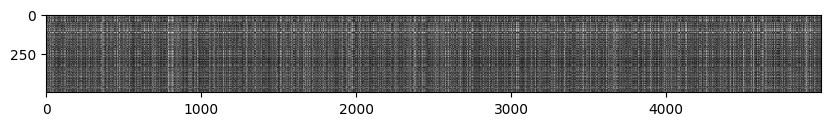

In [8]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
# 可视化距离矩阵: 每一行是一个测试样本及其与训练样本的距离
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1**

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ 

注意距离矩阵中的结构化模式，其中一些行或列明显更亮。（请注意，在默认配色方案中，黑色表示低距离，而白色表示高距离。）

数据中的什么因素导致了这些明显明亮的行和列？

一行是一个测试图像, 明亮的原因是该图像与训练图像差距比较明显. 说明该图像比较特殊, 预测的结果可能不准确
一列是一个训练图像, 明亮的原因是该图像与测试图像差距比较明显. 说明该图像的lable很可能不会在测试结果中出现

In [9]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
# 实现predict_labels函数, 使用k=1的最近邻算法进行预测
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
# 计算并打印正确预测的样本比例
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [10]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply. To clarify, both training and test examples are preprocessed in the same way.

1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data, which means rotating all the images by the same angle. Empty regions in the image caused by rotation are padded with a same pixel value and no interpolation is performed.


我们也可以使用其他距离度量，如 L1 距离。
对于某图像 $I_k$ 在位置 $(i,j)$ 的像素值 $p_{ij}^{(k)}$，
所有图像所有像素的平均值 $\mu$ 为：$$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
而所有图像在位置 $(i,j)$ 的像素均值 $\mu_{ij}$ 为：
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
一般标准差 $\sigma$ 和逐像素标准差 $\sigma_{ij}$ 的定义类似。
以下哪些预处理步骤不会改变使用 L1 距离的最近邻分类器的性能？选择所有适用的选项。需要说明的是，训练样本和测试样本都以相同的方式进行预处理。
1. 减去均值 $\mu$ ($\tilde{p}{ij}^{(k)}=p{ij}^{(k)}-\mu$)
2. 减去每个像素位置的均值 $\mu_{ij}$ ($\tilde{p}{ij}^{(k)}=p{ij}^{(k)}-\mu_{ij}$)
3. 减去均值 $\mu$ 并除以标准差 $\sigma$
4. 减去逐像素均值 $\mu_{ij}$ 并除以逐像素标准差 $\sigma_{ij}$
5. 旋转数据的坐标轴，即将所有图像旋转相同的角度。旋转导致的图像空白区域用相同的像素值填充，且不执行插值。

$\color{blue}{\textit Your Answer:}$

预处理步骤不会改变性能的有：1, 2, 3

**解释**：

首先，我们需要做一些假设。考虑 $p^{(k)}$ 是我们的像素向量，它是一个图像 $I_k$ 的像素值的扁平化矩阵。共有 $S = h \times w$ 个值，其中每个条目 $p_m^{(k)}$ 在 $p^{(k)}$ 中对应于 $I_k$ 中的每个条目 $p_{ij}^{(k)}$。

让我们回忆一下 $L1$ 是如何在不同图像的两个像素向量之间计算的：

$$d_1(p^{(k)}, p^{(k')}) = ||p^{(k)} - p^{(k')}||_1$$

其中 $L1$ 范数表示为 $||-||_1$ 并按如下方式计算：

$$||p^{(k)} - p^{(k')}||_1 = \sum_{m=1}^{S} |p_m^{(k)} - p_m^{(k')}|$$

由于距离是按像素元素计算的，可以推导出只有最后一个预处理步骤可能会改变 $L1$ 距离，从而改变分类器性能：

1.均值减法

- 公式：$\sum_{m=1}^{S} |(p_m^{(k)} - \mu) - (p_m^{(k')} - \mu)|$

- 解释：可以看出 $\mu$ 在距离计算中会抵消，因为两个像素值都被相同的常数修改。

2.逐像素均值减法

- 公式：$\sum_{m=1}^{S} |(p_m^{(k)} - \mu_m) - (p_m^{(k')} - \mu_m)|$

- 解释：与 1 相同

3.标准化

- 公式：$\sum_{m=1}^{S} |(\frac{p_m^{(k)}-\mu}{\sigma}) - (\frac{p_m^{(k')}-\mu}{\sigma})|$

- 解释：可以看出 $\sigma^{-1}$ 是一个常数，对每个绝对差进行加权。所有差异的常数相同，因此每个距离都按相同的量缩放。这意味着性能不受影响，因为距离比较保持不变（只是在不同的比例上）。

4.逐像素标准化

- 公式：$\sum_{m=1}^{S} |(\frac{p_m^{(k)}-\mu_m}{\sigma_m}) - (\frac{p_m^{(k')}-\mu_m}{\sigma_m})|$

- 解释：可以看出 $\sigma_m^{-1}$ 是一个常数，对每个绝对差进行加权。但每个差异的常数不同，因此一些差异会变得比原来更突出，而其他差异的常数可能对差异影响不大。

示例：假设 $p^{(k)}=[0,0]$, $p^{(k')}=[0,0.9]$, $p^{(k'')}=[1,0.1]$ 和 $\mu=[0,0]$

标准化前距离：

- $d_1(p^{(k)},p^{(k')})=0+0.9=0.9$

- $d_1(p^{(k)},p^{(k'')})=1+0.1=1.1$

标准化后距离：

- $d_1(p^{(k)},p^{(k')})=1 \cdot 0+10 \cdot 0.9=10$

- $d_1(p^{(k)},p^{(k'')})=1 \cdot 1+10 \cdot 0.1=2$

我们可以看到标准化前 $d_1(p^{(k)},p^{(k')}) < d_1(p^{(k)},p^{(k'')})$，但标准化后 $d_1(p^{(k)},p^{(k')}) > d_1(p^{(k)},p^{(k'')})$

5.旋转

- 公式：$||R(p^{(k)}) - R(p^{(k')})||_1$

- 解释：公式表明对向量应用旋转与在保留其距离的同时变换其空间相同（来源：维基百科）。然而，这意味着某些轴的变换取决于另一个轴，而不像之前的情况那样是某个常数。因此，两个不同向量在变换后的距离会不同，因为两个向量空间的（未归一化）基通常是不同的。

- 示例：假设 $p^{(k)}=[1,0]$, $p^{(k')}=[1,1]$, $p^{(k'')}=[2,2]$ 和 $$R=\begin{bmatrix} \cos(\pi/2) & -\sin(\pi/2) \\ \sin(\pi/2) & \cos(\pi/2) \end{bmatrix}=\begin{bmatrix} 0 & -1 \\ 1 & 0 \end{bmatrix}$$(这个矩阵代表逆时针旋转 90 度（$\pi/2$ 弧度）)

1. 对于 $p^{(k)}=[1,0]$：

$$R \cdot p^{(k)} = \begin{bmatrix} 0 & -1 \\ 1 & 0 \end{bmatrix} \cdot \begin{bmatrix} 1 \\ 0 \end{bmatrix} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$$

2. 对于 $p^{(k')}=[1,1]$：

$$R \cdot p^{(k')} = \begin{bmatrix} 0 & -1 \\ 1 & 0 \end{bmatrix} \cdot \begin{bmatrix} 1 \\ 1 \end{bmatrix} = \begin{bmatrix} -1 \\ 1 \end{bmatrix}$$

3. 对于 $p^{(k'')}=[2,2]$：

$$R \cdot p^{(k'')} = \begin{bmatrix} 0 & -1 \\ 1 & 0 \end{bmatrix} \cdot \begin{bmatrix} 2 \\ 2 \end{bmatrix} = \begin{bmatrix} -2 \\ 2 \end{bmatrix}$$

旋转前的距离：

- $d_1(p^{(k)},p^{(k')}) = |1-1| + |0-1| = 0 + 1 = 1$ 

- $d_1(p^{(k)},p^{(k'')}) = |1-2| + |0-2| = 1 + 2 = 3$ 

旋转后的距离：

- $d_1(R \cdot p^{(k)}, R \cdot p^{(k')}) = |0-(-1)| + |1-1| = 1 + 0 = 1$

- $d_1(R \cdot p^{(k)}, R \cdot p^{(k'')}) = |0-(-2)| + |1-2| = 2 + 1 = 3$

注意：此处使用了特殊的旋转矩阵, 通过几何含义理解, L1 距离是两个向量在不同维度下的差值绝对值相加. 在旋转 90 度之后 ▲x +▲y 的值并未改变.

虽然不严谨但是有概率看到旋转前 $d_1(p^{(k)},p^{(k')}) < d_1(p^{(k)},p^{(k'')})$，旋转后 $d_1(p^{(k)},p^{(k')}) > d_1(p^{(k)},p^{(k'')})$

根据上述分析，我们可以得出以下结论：

1. 均值减法（选项 1）不会改变 L1 距离计算结果，因为从所有像素减去相同常数时，绝对差值保持不变。

2. 逐像素均值减法（选项 2）同样不会改变 L1 距离，因为对应位置的像素都减去相同的值。

3. 标准化（选项 3）虽然会对所有距离进行等比例缩放（除以 $\sigma$），但不会改变距离的相对大小关系，因此不会影响最近邻分类器的性能。

4. 逐像素标准化（选项 4）会改变距离的相对大小关系，因为不同位置的像素被不同的标准差缩放，这会导致某些差异变得更加突出，从而可能改变最近邻的结果。所以作为系数的标准差一定要保证是全局(一张图片里所有像素的平均值 p 与所有图片里所有像素的平均值 miu 之间的计算)一致的.

5. 旋转（选项 5）会改变 L1 距离计算，因为旋转会改变像素的空间位置关系. 导致计算结果不同.

   直观理解, 如果一些图片特征化位置被移出, 而一些没有, 那么在计算相似度的时候会产生很大影响

In [11]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
# 编写compute_distances_one_loop. 训练提速.
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
# 在这里我们判断两个矩阵是否相似最简单的一种方法是 Frobenius 范数. 两个矩阵的 Frobenius 范数是所有元素差的平方和的平方根, 也就是将两个矩阵重塑为向量后它们之间的欧几里得距离。我们判断该范数是否difference < 0.001.
# np.linalg.norm()函数就是在计算Frobenius 范数. np.linalg.norm(dists - dists_one, ord='fro')意味着np.sqrt(np.sum((...-...)**2))
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [12]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [13]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using,
# you might not see a speedup when you go from two loops to one loop,
# and might even see a slow-down.

Two loop version took 29.758586 seconds
One loop version took 55.655333 seconds
No loop version took 0.185299 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [15]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = np.array_split(X_train, num_folds, axis=0)
y_train_folds = np.array_split(y_train, num_folds, axis=0)
# X_train_folds, y_train_folds

([array([[ 59.,  62.,  63., ..., 123.,  92.,  72.],
         [154., 177., 187., ..., 143., 133., 144.],
         [255., 255., 255., ...,  80.,  86.,  84.],
         ...,
         [145., 148., 157., ..., 126., 160.,  91.],
         [146., 146., 146., ..., 238., 238., 238.],
         [203., 206., 208., ..., 132., 131., 126.]], shape=(1000, 3072)),
  array([[242., 243., 250., ..., 105., 123., 135.],
         [ 56.,  50.,  28., ..., 131., 112.,  86.],
         [100.,  86.,  89., ...,  44.,  49.,  48.],
         ...,
         [ 41.,  47.,  35., ..., 161., 149.,  89.],
         [ 66., 101., 131., ..., 171., 176., 186.],
         [124., 190., 225., ..., 138., 145., 110.]], shape=(1000, 3072)),
  array([[255., 255., 247., ...,  53.,  52.,  45.],
         [119., 103.,  92., ...,  95., 113., 126.],
         [255., 255., 255., ..., 159., 160., 164.],
         ...,
         [ 29.,  32.,  32., ..., 212., 215., 207.],
         [171., 151., 119., ..., 166., 147., 117.],
         [213., 219., 244., ..

In [35]:
# test 查看folds结构
np.vstack([X_train_folds[j] for j in range(num_folds) if j != 1]), np.hstack([y_train_folds[j] for j in range(num_folds) if j != 1])

(array([[ 59.,  62.,  63., ..., 123.,  92.,  72.],
        [154., 177., 187., ..., 143., 133., 144.],
        [255., 255., 255., ...,  80.,  86.,  84.],
        ...,
        [167., 163., 145., ...,  42.,  78.,  84.],
        [154., 152., 125., ..., 194., 247., 114.],
        [ 45.,  32.,  21., ..., 156., 142., 100.]], shape=(4000, 3072)),
 array([6, 9, 9, ..., 5, 4, 6], shape=(4000,)))

In [ ]:
k_to_accuracies = {}

for k in k_choices:
    accuracyListK = []
    for i in range(num_folds):
        # X_train_val.shape = (1000, 3072)
        # 使用第i折作为验证集
        X_val_cross = X_train_folds[i]
        y_val_cross = y_train_folds[i]
        # 合并其他折叠为训练集(train竖直堆叠, test由于是一维数组水平堆叠)
        X_train_cross = np.vstack([X_train_folds[j] for j in range(num_folds) if j != i])
        y_train_cross = np.hstack([y_train_folds[j] for j in range(num_folds) if j != i])

        # 构建一个knn实例
        classifierForCrossVal = KNearestNeighbor()
        # 训练knn(本质是将train图像+标签传入)
        classifierForCrossVal.train(X_train_cross, y_train_cross)
        # validation: 调用compute_distances_no_loops计算距离矩阵(计算train与val数据之间的距离)
        distsCross = classifierForCrossVal.compute_distances_no_loops(X_val_cross)
        # 预测结果: 调用predict_labels计算预测标签
        y_val_pred_cross = classifierForCrossVal.predict_labels(distsCross, k)
        # 计算val准确率
        num_correct = np.sum(y_val_pred_cross == y_val_cross)
        num_test = y_val_cross.shape[0]
        accuracy = float(num_correct) / num_test
        print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        accuracyListK.append(accuracy)

    k_to_accuracies[k] = accuracyListK
    

# Print out the computed accuracies
# 打印字典
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

Got 263 / 1000 correct => accuracy: 0.263000
Got 257 / 1000 correct => accuracy: 0.257000
Got 264 / 1000 correct => accuracy: 0.264000
Got 278 / 1000 correct => accuracy: 0.278000
Got 266 / 1000 correct => accuracy: 0.266000
Got 239 / 1000 correct => accuracy: 0.239000
Got 249 / 1000 correct => accuracy: 0.249000
Got 240 / 1000 correct => accuracy: 0.240000
Got 266 / 1000 correct => accuracy: 0.266000
Got 254 / 1000 correct => accuracy: 0.254000
Got 248 / 1000 correct => accuracy: 0.248000
Got 266 / 1000 correct => accuracy: 0.266000
Got 280 / 1000 correct => accuracy: 0.280000
Got 292 / 1000 correct => accuracy: 0.292000
Got 280 / 1000 correct => accuracy: 0.280000
Got 262 / 1000 correct => accuracy: 0.262000
Got 282 / 1000 correct => accuracy: 0.282000
Got 273 / 1000 correct => accuracy: 0.273000
Got 290 / 1000 correct => accuracy: 0.290000
Got 273 / 1000 correct => accuracy: 0.273000
Got 265 / 1000 correct => accuracy: 0.265000
Got 296 / 1000 correct => accuracy: 0.296000
Got 276 / 

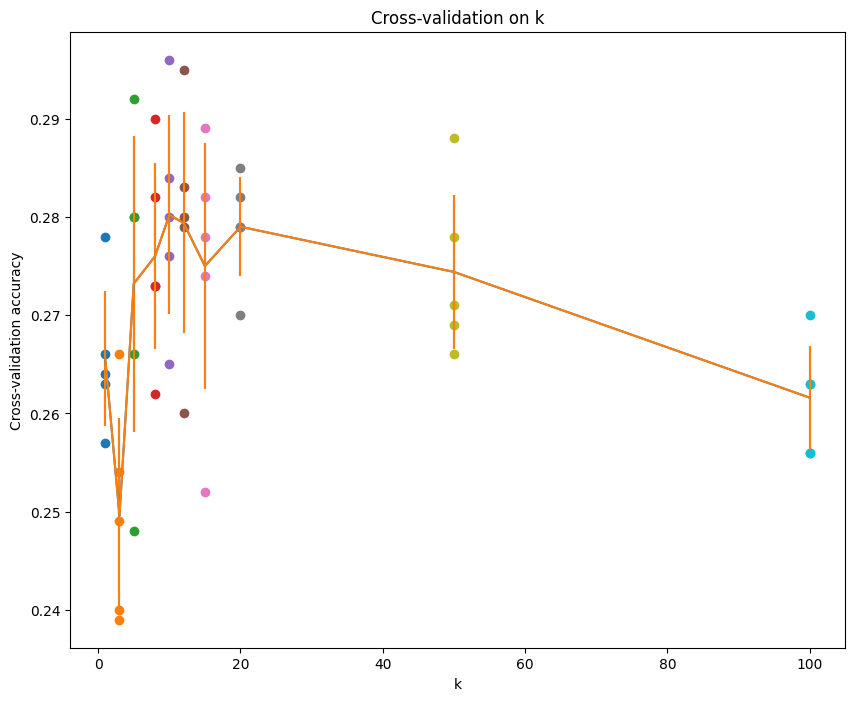

In [45]:
# 绘制k & Cross-validation accuracy 图像
# plot the raw observations
for k in k_choices:
    # 列表
    accuracies = k_to_accuracies[k]
    # scatter函数用于绘制散点图，这里x轴是k（重复len(accuracies)次），y轴是每次交叉验证的准确率
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
# 计算每个k对应的交叉验证准确率的均值，形成一个数组
# 这里的列表推导式 [np.mean(v) for k,v in sorted(k_to_accuracies.items())] 会遍历k_to_accuracies字典中所有的(k, v)对，
# 其中k是k值，v是该k下所有交叉验证准确率的列表。对每个v用np.mean计算均值，最终得到一个均值列表，再转为numpy数组。
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])

# 计算每个k对应的交叉验证准确率的标准差，形成一个数组
# 这里的列表推导式 [np.std(v) for k,v in sorted(k_to_accuracies.items())] 同样遍历k_to_accuracies字典，
# 对每个k下的准确率列表v用np.std计算标准差，最终得到一个标准差列表，再转为numpy数组。
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])

# 绘制带有误差棒的折线图
# plt.errorbar函数用于绘制带有误差棒的折线图
# 第一个参数k_choices：x轴的k值列表
# 第二个参数accuracies_mean：每个k对应的交叉验证准确率均值，作为y轴数据
# 第三个参数yerr=accuracies_std：每个k对应的准确率标准差，作为y轴误差棒的长度
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()
# k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

In [58]:
# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
# 根据上面的交叉验证结果，选择最优的k值，
# 用所有训练数据重新训练分类器，并在测试集上进行测试。
# 你应该能在测试集上获得超过28%的准确率。
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
# 计算并输出准确率
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))


Got 141 / 500 correct => accuracy: 0.282000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
关于$k$近邻（$k$-NN）分类器，下列哪些说法在分类任务中对所有$k$都成立？请选择所有正确选项。
1. The decision boundary of the k-NN classifier is linear.
   k-NN分类器的决策边界是线性的。
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
   1-NN的训练误差总是小于或等于5-NN的训练误差。
3. The test error of a 1-NN will always be lower than that of a 5-NN.
   1-NN的测试误差总是小于5-NN的测试误差。
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
   用k-NN分类器对测试样本进行分类所需的时间会随着训练集规模的增加而增加。
5. None of the above.
   以上都不正确。

A: 

选项1：k-NN分类器的决策边界是线性的

这个说法是错误的。k-NN的决策边界取决于局部数据点的分布，因此通常是非线性、不规则的。决策边界会随着数据点的分布而弯曲变形，适应数据的自然结构。

选项2：1-NN的训练误差总是小于或等于5-NN的训练误差

这个说法是正确的。训练误差是指模型在训练数据上的分类错误率。对于1-NN，每个训练样本的最近邻就是它自己，所以训练错误率为0。而5-NN会考虑更多邻居的投票，可能会导致一些训练样本被错误分类。

选项3：1-NN的测试误差总是小于5-NN的测试误差

这个说法是错误的。测试误差是模型在新数据上的错误率。1-NN容易过拟合（对训练数据记忆太强），而5-NN通过考虑多个邻居，能更好地处理噪声和异常值，通常有更好的泛化能力。

选项4：用k-NN分类器对测试样本进行分类所需的时间会随着训练集规模的增加而增加

这个说法是正确的。k-NN必须计算测试样本与所有训练样本之间的距离，所以计算时间随训练集大小线性增长。